# 02 - Correlation Analysis

Compute Pearson, Spearman, and Kendall correlations between metrics and human simplicity scores.
All correlations are reported as **absolute values** with **95% confidence intervals**.

CI Methods:
- **Pearson**: Fisher's z-transformation
- **Spearman**: Fisher z with Bonett-Wright (2000) SE adjustment
- **Kendall**: Asymptotic normal approximation

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import load_all_datasets, get_metric_names
from src.statistics import compute_all_correlations, compute_metric_correlations

plt.style.use('seaborn-v0_8-whitegrid')

results_dir = project_root / 'results'
figures_dir = results_dir / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)

print('Setup complete!')

Setup complete!


## 1. Load Datasets

In [2]:
datasets = load_all_datasets()

Loading all datasets...

ARTS:
  ARTS94: 94 samples, 10 metrics
  ARTS300: 300 samples, 10 metrics
  ARTS3k: 2999 samples, 10 metrics

LR-ARTS (Length-Residualized):
  LR-ARTS94: 94 samples, 10 metrics [LENGTH-RESIDUALIZED]
  LR-ARTS300: 300 samples, 10 metrics [LENGTH-RESIDUALIZED]
  LR-ARTS3k: 2999 samples, 10 metrics [LENGTH-RESIDUALIZED]

SDA:
  SDA: 600 samples, 26 metrics

Human-annotated:
  ST-sent: 1620 samples, 26 metrics, scale (1, 7)
  ST-para: 271 samples, 26 metrics, scale (1, 7)
  D-Wiki: 601 samples, 26 metrics, scale (1, 5)


## 2. Compute All Correlations (Pearson, Spearman, Kendall)

In [3]:
# Compute all three correlation types for each dataset
correlation_results = {}

for dataset_name, data in datasets.items():
    print(f'\n{dataset_name}:')
    
    human = data['human_scores']
    metrics = {k: v for k, v in data['metric_scores'].items() if k != 'human'}
    
    # Compute Pearson, Spearman, and Kendall correlations
    corr_df = compute_all_correlations(metrics, human)
    correlation_results[dataset_name] = corr_df
    
    print(f'  Samples: {data["n_samples"]}')
    print(f'  Metrics: {len(corr_df)}')
    if len(corr_df) > 0:
        best = corr_df.iloc[0]
        print(f'  Best (avg |r|): {best["metric"]} ({best["avg_abs"]:.3f})')


ARTS94:
  Samples: 94
  Metrics: 10
  Best (avg |r|): Ours_RF (0.729)

ARTS300:
  Samples: 300
  Metrics: 10
  Best (avg |r|): Claude(simp) (0.685)

ARTS3k:
  Samples: 2999
  Metrics: 10
  Best (avg |r|): Claude(simp) (0.659)

LR-ARTS94:
  Samples: 94
  Metrics: 10
  Best (avg |r|): Claude(simp) (0.446)

LR-ARTS300:
  Samples: 300
  Metrics: 10
  Best (avg |r|): Claude(simp) (0.534)

LR-ARTS3k:
  Samples: 2999
  Metrics: 10
  Best (avg |r|): Claude(simp) (0.524)

SDA:
  Samples: 600
  Metrics: 26
  Best (avg |r|): Claude(simp+src+ref) (0.683)

ST-sent:
  Samples: 1620
  Metrics: 26
  Best (avg |r|): BATS-RF (0.629)

ST-para:
  Samples: 271
  Metrics: 26
  Best (avg |r|): SARI (0.329)

D-Wiki:
  Samples: 601
  Metrics: 26
  Best (avg |r|): Claude(simp+src) (0.574)


## 3. Correlation Tables by Dataset

Showing absolute correlations (|r|) for Pearson, Spearman, and Kendall's tau.

In [4]:
# Display correlation tables for key datasets with confidence intervals
for dataset_name in ['ARTS3k', 'SDA', 'ST-sent', 'D-Wiki']:
    if dataset_name in correlation_results:
        print(f'\n{dataset_name} - Absolute Correlations with 95% CIs:')
        print('=' * 100)
        
        df = correlation_results[dataset_name].copy()
        
        # Format correlations with CIs
        def format_with_ci(row, corr_col, ci_lower_col, ci_upper_col):
            r = row[corr_col]
            ci_l = abs(row[ci_lower_col])  # Absolute for display
            ci_u = abs(row[ci_upper_col])
            if pd.isna(r):
                return "N/A"
            return f"{r:.3f} [{min(ci_l, ci_u):.3f}, {max(ci_l, ci_u):.3f}]"
        
        display_df = pd.DataFrame({
            'Metric': df['metric'],
            'Pearson |r| [95% CI]': df.apply(lambda r: format_with_ci(r, 'P_abs', 'P_ci_lower', 'P_ci_upper'), axis=1),
            'Spearman |ρ| [95% CI]': df.apply(lambda r: format_with_ci(r, 'S_abs', 'S_ci_lower', 'S_ci_upper'), axis=1),
            'Kendall |τ| [95% CI]': df.apply(lambda r: format_with_ci(r, 'K_abs', 'K_ci_lower', 'K_ci_upper'), axis=1),
            'N': df['n'].astype(int),
        })
        
        display(display_df.head(15))


ARTS3k - Absolute Correlations with 95% CIs:


,Metric,Pearson |r| [95% CI],Spearman |ρ| [95% CI],Kendall |τ| [95% CI],N
4,Claude(simp),"0.688 [0.669, 0.707]","0.721 [0.702, 0.740]","0.568 [0.544, 0.592]",2999
7,Ours_RF,"0.621 [0.598, 0.642]","0.620 [0.595, 0.643]","0.439 [0.415, 0.463]",2999
0,SLE,"0.613 [0.591, 0.635]","0.618 [0.593, 0.641]","0.437 [0.413, 0.461]",2999
2,Word_Count,"0.530 [0.504, 0.556]","0.563 [0.536, 0.589]","0.400 [0.377, 0.424]",2999
1,FKGL,"0.492 [0.464, 0.518]","0.482 [0.452, 0.510]","0.334 [0.310, 0.358]",2999
9,BATS-RF,"0.442 [0.413, 0.470]","0.439 [0.408, 0.469]","0.306 [0.282, 0.330]",2999
8,BATS-GB,"0.424 [0.394, 0.453]","0.420 [0.389, 0.451]","0.292 [0.269, 0.316]",2999
3,Avg_Word_Len,"0.149 [0.114, 0.184]","0.166 [0.131, 0.201]","0.112 [0.088, 0.136]",2999
5,Random,"0.027 [0.009, 0.063]","0.027 [0.009, 0.063]","0.018 [0.006, 0.042]",2999
6,Shuffle,"0.006 [0.030, 0.042]","0.006 [0.030, 0.042]","0.004 [0.020, 0.028]",2999



SDA - Absolute Correlations with 95% CIs:


,Metric,Pearson |r| [95% CI],Spearman |ρ| [95% CI],Kendall |τ| [95% CI],N
18,Claude(simp+src+ref),"0.725 [0.685, 0.761]","0.745 [0.702, 0.783]","0.578 [0.524, 0.631]",600
16,Claude(simp+src),"0.676 [0.630, 0.717]","0.730 [0.685, 0.770]","0.573 [0.520, 0.627]",600
17,Claude(simp+ref),"0.639 [0.589, 0.684]","0.635 [0.580, 0.685]","0.484 [0.430, 0.537]",600
23,LENS-SALSA,"0.573 [0.517, 0.624]","0.683 [0.632, 0.727]","0.493 [0.440, 0.547]",600
10,BERTScore_P,"0.567 [0.510, 0.619]","0.603 [0.544, 0.655]","0.428 [0.374, 0.481]",600
12,bertscore_f1,"0.476 [0.411, 0.535]","0.459 [0.390, 0.523]","0.322 [0.268, 0.375]",600
15,Claude(simp),"0.363 [0.292, 0.431]","0.341 [0.266, 0.412]","0.255 [0.201, 0.308]",600
11,bertscore_r,"0.365 [0.294, 0.432]","0.347 [0.272, 0.418]","0.241 [0.187, 0.294]",600
8,rouge2,"0.334 [0.261, 0.404]","0.301 [0.225, 0.374]","0.205 [0.152, 0.259]",600
3,D-SARI,"0.328 [0.255, 0.398]","0.298 [0.222, 0.371]","0.202 [0.149, 0.256]",600



ST-sent - Absolute Correlations with 95% CIs:


,Metric,Pearson |r| [95% CI],Spearman |ρ| [95% CI],Kendall |τ| [95% CI],N
20,BATS-RF,"0.676 [0.648, 0.701]","0.684 [0.654, 0.712]","0.529 [0.496, 0.561]",1620
25,Ours_RF,"0.673 [0.645, 0.698]","0.684 [0.654, 0.712]","0.528 [0.495, 0.560]",1620
19,BATS-GB,"0.667 [0.640, 0.694]","0.676 [0.645, 0.704]","0.520 [0.488, 0.553]",1620
21,Claude(simp),"0.465 [0.426, 0.502]","0.478 [0.438, 0.517]","0.376 [0.344, 0.409]",1620
10,rouge2,"0.385 [0.343, 0.426]","0.393 [0.349, 0.435]","0.286 [0.254, 0.319]",1620
3,Word_Count,"0.339 [0.295, 0.382]","0.409 [0.366, 0.451]","0.299 [0.267, 0.332]",1620
8,BLEU,"0.348 [0.304, 0.390]","0.368 [0.323, 0.411]","0.267 [0.234, 0.299]",1620
0,SLE,"0.340 [0.296, 0.382]","0.366 [0.321, 0.408]","0.264 [0.232, 0.297]",1620
15,dsari_delete,"0.331 [0.286, 0.373]","0.359 [0.315, 0.402]","0.259 [0.226, 0.291]",1620
9,rouge1,"0.335 [0.291, 0.377]","0.345 [0.300, 0.388]","0.249 [0.217, 0.282]",1620



D-Wiki - Absolute Correlations with 95% CIs:


,Metric,Pearson |r| [95% CI],Spearman |ρ| [95% CI],Kendall |τ| [95% CI],N
22,Claude(simp+src),"0.574 [0.518, 0.625]","0.629 [0.574, 0.680]","0.518 [0.464, 0.571]",601
20,BATS-RF,"0.608 [0.555, 0.656]","0.617 [0.560, 0.668]","0.460 [0.407, 0.514]",601
24,Claude(simp+src+ref),"0.522 [0.462, 0.578]","0.595 [0.536, 0.649]","0.477 [0.424, 0.530]",601
25,Ours_RF,"0.579 [0.523, 0.630]","0.582 [0.522, 0.636]","0.428 [0.374, 0.481]",601
19,BATS-GB,"0.555 [0.497, 0.608]","0.555 [0.492, 0.611]","0.410 [0.357, 0.464]",601
23,Claude(simp+ref),"0.497 [0.435, 0.555]","0.516 [0.450, 0.576]","0.402 [0.349, 0.456]",601
14,dsari_keep,"0.486 [0.422, 0.545]","0.481 [0.413, 0.543]","0.351 [0.298, 0.405]",601
1,LENS-SALSA,"0.448 [0.382, 0.510]","0.450 [0.380, 0.514]","0.326 [0.272, 0.379]",601
21,Claude(simp),"0.495 [0.432, 0.553]","0.369 [0.295, 0.438]","0.294 [0.241, 0.348]",601
12,SARI,"0.368 [0.297, 0.435]","0.358 [0.284, 0.428]","0.257 [0.204, 0.311]",601


## 4. Cross-Dataset Comparison Tables

Separate tables for Pearson, Spearman, and Kendall absolute correlations.

In [5]:
# Build separate comparison matrices for each correlation method
all_metrics = set()
for df in correlation_results.values():
    all_metrics.update(df['metric'].tolist())

col_order = ['ARTS94', 'ARTS300', 'ARTS3k', 'LR-ARTS94', 'LR-ARTS300', 'LR-ARTS3k', 'SDA', 'ST-sent', 'ST-para', 'D-Wiki']

def build_correlation_table(correlation_results, corr_col, col_order):
    """Build a metrics x datasets table for a specific correlation type."""
    comparison_data = {}
    for dataset_name, df in correlation_results.items():
        metric_to_corr = dict(zip(df['metric'], df[corr_col]))
        comparison_data[dataset_name] = metric_to_corr
    
    table = pd.DataFrame(comparison_data)
    cols = [c for c in col_order if c in table.columns]
    table = table[cols]
    table['Average'] = table.mean(axis=1)
    table = table.sort_values('Average', ascending=False)
    return table

def build_ci_table(correlation_results, ci_col, col_order):
    """Build CI bounds table (lower or upper)."""
    comparison_data = {}
    for dataset_name, df in correlation_results.items():
        metric_to_ci = dict(zip(df['metric'], df[ci_col].abs()))
        comparison_data[dataset_name] = metric_to_ci
    
    table = pd.DataFrame(comparison_data)
    cols = [c for c in col_order if c in table.columns]
    table = table[cols]
    return table

def build_formatted_table(correlation_results, corr_col, ci_lower_col, ci_upper_col, col_order):
    """Build a formatted table with r [CI_lower, CI_upper]."""
    comparison_data = {}
    for dataset_name, df in correlation_results.items():
        formatted = {}
        for _, row in df.iterrows():
            r = row[corr_col]
            ci_l = abs(row[ci_lower_col])
            ci_u = abs(row[ci_upper_col])
            if pd.isna(r):
                formatted[row['metric']] = ""
            else:
                formatted[row['metric']] = f"{r:.3f} [{min(ci_l, ci_u):.3f}, {max(ci_l, ci_u):.3f}]"
        comparison_data[dataset_name] = formatted
    
    table = pd.DataFrame(comparison_data)
    cols = [c for c in col_order if c in table.columns]
    table = table[cols]
    
    # Add average (compute from numeric values)
    corr_table = build_correlation_table(correlation_results, corr_col, col_order)
    table = table.reindex(corr_table.index)
    table['Average'] = corr_table['Average'].round(3).astype(str)
    return table

# Create point estimate tables (for heatmaps)
pearson_table = build_correlation_table(correlation_results, 'P_abs', col_order)
spearman_table = build_correlation_table(correlation_results, 'S_abs', col_order)
kendall_table = build_correlation_table(correlation_results, 'K_abs', col_order)

# Create CI bounds tables
pearson_ci_lower = build_ci_table(correlation_results, 'P_ci_lower', col_order).reindex(pearson_table.index)
pearson_ci_upper = build_ci_table(correlation_results, 'P_ci_upper', col_order).reindex(pearson_table.index)
spearman_ci_lower = build_ci_table(correlation_results, 'S_ci_lower', col_order).reindex(spearman_table.index)
spearman_ci_upper = build_ci_table(correlation_results, 'S_ci_upper', col_order).reindex(spearman_table.index)
kendall_ci_lower = build_ci_table(correlation_results, 'K_ci_lower', col_order).reindex(kendall_table.index)
kendall_ci_upper = build_ci_table(correlation_results, 'K_ci_upper', col_order).reindex(kendall_table.index)

# Create formatted tables with CIs
pearson_formatted = build_formatted_table(correlation_results, 'P_abs', 'P_ci_lower', 'P_ci_upper', col_order)
spearman_formatted = build_formatted_table(correlation_results, 'S_abs', 'S_ci_lower', 'S_ci_upper', col_order)
kendall_formatted = build_formatted_table(correlation_results, 'K_abs', 'K_ci_lower', 'K_ci_upper', col_order)

In [12]:
# Display formatted tables with 95% CIs

print('=' * 120)
print('PEARSON |r| with 95% Confidence Intervals')
print('=' * 120)
print(pearson_formatted)

print('\n' + '=' * 120)
print('SPEARMAN |ρ| with 95% Confidence Intervals')
print('=' * 120)
print(spearman_formatted)

print('\n' + '=' * 120)
print('KENDALL |τ| with 95% Confidence Intervals')
print('=' * 120)
print(kendall_formatted)

PEARSON |r| with 95% Confidence Intervals
                                    ARTS94               ARTS300  \
Claude(simp)          0.682 [0.556, 0.777]  0.727 [0.669, 0.777]   
Ours_RF               0.792 [0.702, 0.857]  0.663 [0.594, 0.722]   
BATS-GB               0.774 [0.678, 0.844]  0.662 [0.593, 0.721]   
BATS-RF               0.737 [0.628, 0.817]  0.655 [0.585, 0.715]   
Claude(simp+src)                       NaN                   NaN   
Claude(simp+src+ref)                   NaN                   NaN   
SLE                   0.702 [0.582, 0.792]  0.642 [0.570, 0.704]   
LENS-SALSA                             NaN                   NaN   
Claude(simp+ref)                       NaN                   NaN   
SARI                                   NaN                   NaN   
bertscore_f1                           NaN                   NaN   
BERTScore_P                            NaN                   NaN   
FKGL                  0.588 [0.438, 0.707]  0.499 [0.409, 0.580]   
D-SARI

## 5. Correlation Heatmap

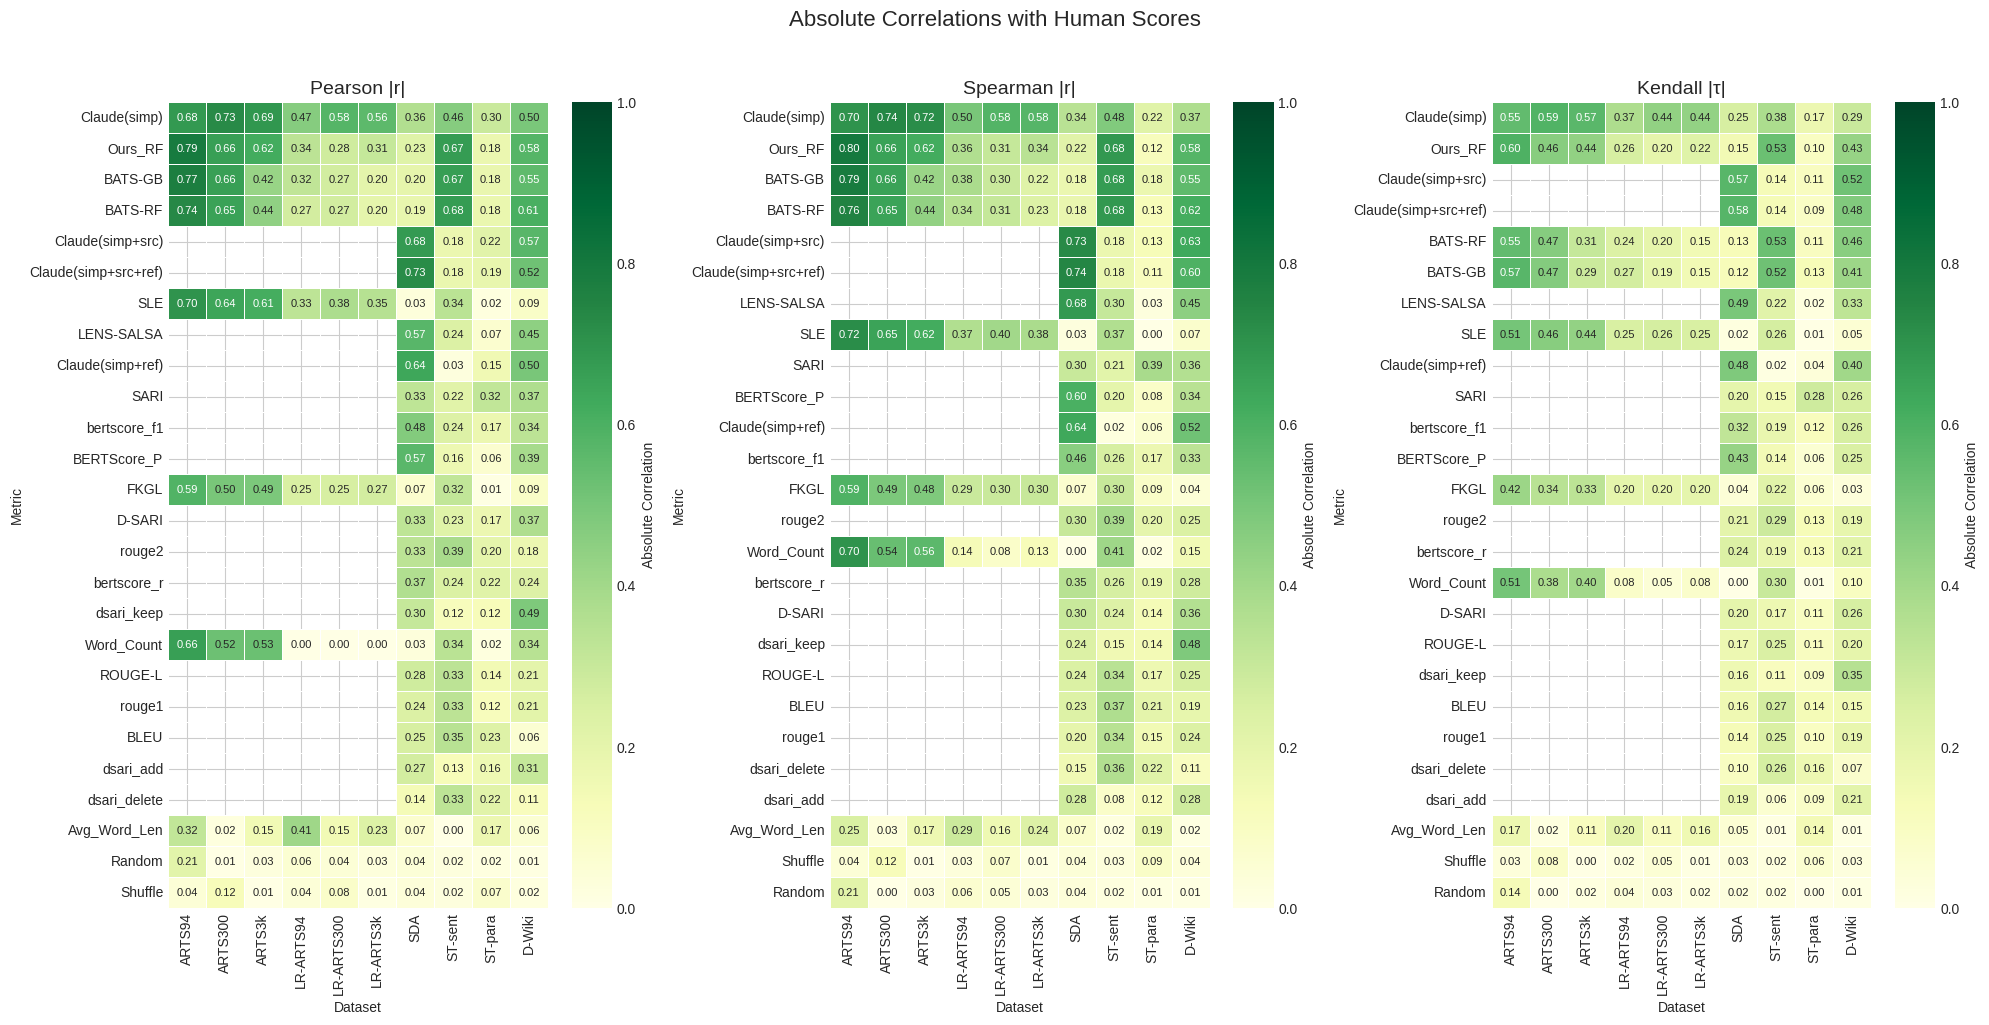

Saved: correlation_heatmaps.png/pdf


In [7]:
# Heatmaps for each correlation method
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

tables = [
    (pearson_table, 'Pearson |r|'),
    (spearman_table, 'Spearman |r|'),
    (kendall_table, 'Kendall |τ|'),
]

for ax, (table, title) in zip(axes, tables):
    plot_df = table.drop(columns=['Average'])
    
    sns.heatmap(
        plot_df,
        annot=True,
        fmt='.2f',
        cmap='YlGn',
        vmin=0,
        vmax=1,
        ax=ax,
        linewidths=0.5,
        cbar_kws={'label': 'Absolute Correlation'},
        annot_kws={'size': 8},
    )
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Metric')

plt.suptitle('Absolute Correlations with Human Scores', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(figures_dir / 'correlation_heatmaps.png', dpi=150, bbox_inches='tight')
plt.savefig(figures_dir / 'correlation_heatmaps.pdf', bbox_inches='tight')
plt.show()
print('Saved: correlation_heatmaps.png/pdf')

## 6. Save Correlation Tables

In [8]:
# Save correlation tables to CSV (point estimates, CI bounds, and formatted)

# Point estimates (for heatmaps)
pearson_table.round(3).to_csv(results_dir / 'correlation_pearson.csv')
spearman_table.round(3).to_csv(results_dir / 'correlation_spearman.csv')
kendall_table.round(3).to_csv(results_dir / 'correlation_kendall.csv')

# CI bounds
pearson_ci_lower.round(3).to_csv(results_dir / 'correlation_pearson_ci_lower.csv')
pearson_ci_upper.round(3).to_csv(results_dir / 'correlation_pearson_ci_upper.csv')
spearman_ci_lower.round(3).to_csv(results_dir / 'correlation_spearman_ci_lower.csv')
spearman_ci_upper.round(3).to_csv(results_dir / 'correlation_spearman_ci_upper.csv')
kendall_ci_lower.round(3).to_csv(results_dir / 'correlation_kendall_ci_lower.csv')
kendall_ci_upper.round(3).to_csv(results_dir / 'correlation_kendall_ci_upper.csv')

# Formatted tables with CIs (for publication)
pearson_formatted.to_csv(results_dir / 'correlation_pearson_with_ci.csv')
spearman_formatted.to_csv(results_dir / 'correlation_spearman_with_ci.csv')
kendall_formatted.to_csv(results_dir / 'correlation_kendall_with_ci.csv')

print('Saved correlation tables:')
print('  Point estimates:')
print('    - correlation_pearson.csv')
print('    - correlation_spearman.csv')
print('    - correlation_kendall.csv')
print('  95% CI bounds:')
print('    - correlation_pearson_ci_lower.csv / correlation_pearson_ci_upper.csv')
print('    - correlation_spearman_ci_lower.csv / correlation_spearman_ci_upper.csv')
print('    - correlation_kendall_ci_lower.csv / correlation_kendall_ci_upper.csv')
print('  Formatted with CIs:')
print('    - correlation_pearson_with_ci.csv')
print('    - correlation_spearman_with_ci.csv')
print('    - correlation_kendall_with_ci.csv')

Saved correlation tables:
  Point estimates:
    - correlation_pearson.csv
    - correlation_spearman.csv
    - correlation_kendall.csv
  95% CI bounds:
    - correlation_pearson_ci_lower.csv / correlation_pearson_ci_upper.csv
    - correlation_spearman_ci_lower.csv / correlation_spearman_ci_upper.csv
    - correlation_kendall_ci_lower.csv / correlation_kendall_ci_upper.csv
  Formatted with CIs:
    - correlation_pearson_with_ci.csv
    - correlation_spearman_with_ci.csv
    - correlation_kendall_with_ci.csv


## 7. Ranking by Average Absolute Correlation

In [9]:
# Final rankings for each method with average CI width
print('RANKINGS BY AVERAGE ABSOLUTE CORRELATION (with 95% CI)')
print('=' * 90)

def compute_avg_ci_width(metric, ci_lower_table, ci_upper_table):
    """Compute average CI width across datasets for a metric."""
    lower = ci_lower_table.loc[metric].dropna()
    upper = ci_upper_table.loc[metric].dropna()
    widths = (upper - lower).abs()
    return widths.mean() if len(widths) > 0 else np.nan

tables_with_ci = [
    (pearson_table, pearson_ci_lower, pearson_ci_upper, 'Pearson'),
    (spearman_table, spearman_ci_lower, spearman_ci_upper, 'Spearman'),
    (kendall_table, kendall_ci_lower, kendall_ci_upper, 'Kendall'),
]

for table, ci_lower, ci_upper, method in tables_with_ci:
    table_copy = table.copy()
    table_copy['Count'] = table_copy.drop(columns=['Average']).notna().sum(axis=1)
    table_copy['CI_Width'] = [compute_avg_ci_width(m, ci_lower, ci_upper) for m in table_copy.index]
    ranking = table_copy[['Average', 'CI_Width', 'Count']].sort_values('Average', ascending=False)
    
    print(f'\n{method}:')
    print('-' * 60)
    for i, (metric, row) in enumerate(ranking.head(10).iterrows(), 1):
        ci_half = row['CI_Width'] / 2
        print(f'  {i:2d}. {metric:25s} |r|={row["Average"]:.3f} ± {ci_half:.3f} ({int(row["Count"])} datasets)')

RANKINGS BY AVERAGE ABSOLUTE CORRELATION (with 95% CI)

Pearson:
------------------------------------------------------------
   1. Claude(simp)              |r|=0.532 ± 0.072 (10 datasets)
   2. Ours_RF                   |r|=0.465 ± 0.075 (10 datasets)
   3. BATS-GB                   |r|=0.426 ± 0.077 (10 datasets)
   4. BATS-RF                   |r|=0.423 ± 0.079 (10 datasets)
   5. Claude(simp+src)          |r|=0.411 ± 0.065 (4 datasets)
   6. Claude(simp+src+ref)      |r|=0.404 ± 0.065 (4 datasets)
   7. SLE                       |r|=0.349 ± 0.068 (10 datasets)
   8. LENS-SALSA                |r|=0.331 ± 0.057 (4 datasets)
   9. Claude(simp+ref)          |r|=0.329 ± 0.063 (4 datasets)
  10. SARI                      |r|=0.308 ± 0.100 (4 datasets)

Spearman:
------------------------------------------------------------
   1. Claude(simp)              |r|=0.523 ± 0.076 (10 datasets)
   2. Ours_RF                   |r|=0.469 ± 0.078 (10 datasets)
   3. BATS-GB                   |r|=0.4

## 8. Summary

In [10]:
print('CORRELATION ANALYSIS SUMMARY')
print('=' * 70)
print(f'Datasets analyzed: {len(correlation_results)}')
print(f'Unique metrics: {len(all_metrics)}')
print('\nCorrelation methods: Pearson, Spearman, Kendall')
print('All values reported as absolute correlations |r| with 95% CIs')
print('CI method: Fisher z-transformation (Bonett-Wright adjustment for Spearman)')

print('\nBest Metric per Dataset (by Spearman |r| with 95% CI):')
for dataset_name, df in correlation_results.items():
    if len(df) > 0:
        best_idx = df['S_abs'].idxmax()
        best = df.loc[best_idx]
        ci_l = abs(best['S_ci_lower'])
        ci_u = abs(best['S_ci_upper'])
        print(f'  {dataset_name}: {best["metric"]} (|r|={best["S_abs"]:.3f} [{min(ci_l, ci_u):.3f}, {max(ci_l, ci_u):.3f}])')

print('\nTop 5 Overall (by Spearman average with CI width):')
spearman_ranking = spearman_table.copy()
spearman_ranking['Count'] = spearman_ranking.drop(columns=['Average']).notna().sum(axis=1)
spearman_ranking['CI_Width'] = [compute_avg_ci_width(m, spearman_ci_lower, spearman_ci_upper) for m in spearman_ranking.index]
for i, (metric, row) in enumerate(spearman_ranking[['Average', 'CI_Width', 'Count']].sort_values('Average', ascending=False).head(5).iterrows(), 1):
    ci_half = row['CI_Width'] / 2
    print(f'  {i}. {metric}: |r|={row["Average"]:.3f} ± {ci_half:.3f} (in {int(row["Count"])} datasets)')

CORRELATION ANALYSIS SUMMARY
Datasets analyzed: 10
Unique metrics: 26

Correlation methods: Pearson, Spearman, Kendall
All values reported as absolute correlations |r| with 95% CIs
CI method: Fisher z-transformation (Bonett-Wright adjustment for Spearman)

Best Metric per Dataset (by Spearman |r| with 95% CI):
  ARTS94: Ours_RF (|r|=0.799 [0.696, 0.870])
  ARTS300: Claude(simp) (|r|=0.739 [0.675, 0.792])
  ARTS3k: Claude(simp) (|r|=0.721 [0.702, 0.740])
  LR-ARTS94: Claude(simp) (|r|=0.499 [0.318, 0.644])
  LR-ARTS300: Claude(simp) (|r|=0.583 [0.496, 0.659])
  LR-ARTS3k: Claude(simp) (|r|=0.576 [0.550, 0.601])
  SDA: Claude(simp+src+ref) (|r|=0.745 [0.702, 0.783])
  ST-sent: BATS-RF (|r|=0.684 [0.654, 0.712])
  ST-para: SARI (|r|=0.385 [0.193, 0.549])
  D-Wiki: Claude(simp+src) (|r|=0.629 [0.574, 0.680])

Top 5 Overall (by Spearman average with CI width):
  1. Claude(simp): |r|=0.523 ± 0.076 (in 10 datasets)
  2. Ours_RF: |r|=0.469 ± 0.078 (in 10 datasets)
  3. BATS-GB: |r|=0.435 ± 0.0